# Comparing Temperatures and Luminosities Between Analyses

This notebook measures global temperatures and luminosities for the samples we are using to verify our method, then compares them to the measurements from literature. While the focus of this work is the measurement of galaxy cluster masses, temperatures and luminosities play an important role in the construction of X-ray mass-observable scaling relations - thus they must also be shown to be consistent with previous work. 

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs3p_colour, xcs_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sources import GalaxyCluster
from xga.sources import BaseSource
from xga.xspec import single_temp_apec

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### SDSSRM-XCS Volume Limited

This is the recent SDSSRM-XCS sample. The temperatures and luminosities are measured by the XCS luminosity-temperature pipeline, and with this we demonstrate that XGA temperatures and luminosities are consistent with existing XCS results.

In order to achieve maximum consistency, we use the XAPA coordinates as the central position for spectrum generation (turning off the XGA peak finder with `use_peak=False`). We have also made sure to use the same cosmology.

Two files are read in here, one with the results of the XCS3P luminosity-temperature pipeline measured within $R_{500}$ and another with results measured within $R_{2500}$. Not all clusters in the $R_{500}$ sample have a corresponding $R_{2500}$.

In [2]:
xcs3p = pd.read_csv("../../sample_files/xcs3p_sdssrm_vol_lim_temperr_25%_clusters.csv")
xcs3p_r2500 = pd.read_csv("../../sample_files/xcs3p_sdssrm_r2500_props_nonvol_lim_temperr_100%_clusters.csv")

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xcs3p['xapa_ra'].values
dec = xcs3p['xapa_dec'].values
z = xcs3p['z'].values
# Not using the IAU names in XCS_NAME column, its easier for me to use the name based on redMaPPer ID
n = xcs3p['name'].values
# In arcminutes, ClusterSample declaration will convert to kpc using the provided cosmology
r500 = Quantity(xcs3p['r500'].values, 'arcmin')
# Not likely to use richness in this notebook, but I'm putting it in the sample object anyway
r = xcs3p['richness'].values
r_err = xcs3p['richness_err'].values

# Declaring the actual ClusterSample instance for the XCS sample
xcs_srcs = ClusterSample(ra, dec, z, n, r500=r500, richness=r, richness_err=r_err, cosmology=xcs_cosmo, 
                         load_fits=True, use_peak=False, clean_obs=True, clean_obs_reg='r500', 
                         clean_obs_threshold=0.7)

Declaring BaseSource Sample:  31%|█████████████▏                             | 46/150 [00:24<00:35,  2.89it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source SDSSXCS-1884 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  76%|███████████████████████████████▉          | 114/150 [00:58<00:14,  2.47it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source SDSSXCS-210 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Setting up Galaxy Clusters:   7%|██▉                                         | 10/148 [00:05<01:14,  1.86it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-2346 has not been detected in all region files,

Setting up Galaxy Clusters:  22%|█████████▊                                  | 33/148 [01:14<09:09,  4.78s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-120 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  25%|███████████                                 | 37/148 [01:24<04:24,  2.38s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-103 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  28%|████████████▏                               | 41/148 [01:27<02:05,  1.17s/it]/mnt/pac

Setting up Galaxy Clusters:  52%|██████████████████████▉                     | 77/148 [03:16<08:06,  6.86s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-19467 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  53%|███████████████████████▍                    | 79/148 [04:44<25:17, 21.99s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-1174 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  54%|███████████████████████▊                    | 80/148 [04:45<17:47, 15.70s/it]/mnt/

Setting up Galaxy Clusters:  92%|███████████████████████████████████████▌   | 136/148 [06:28<00:18,  1.53s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-110 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters: 150it [06:40,  2.67s/it]                                                          
Generating products of type(s) expmap: 100%|████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Also define another sample with a subset of those clusters, specifically for those clusters that also have an $R_{2500}$ value as measured by the XCS3P luminosity temperature pipeline. A separate sample in this case makes it easier to run XGA measurements of temperature and luminosity within $R_{2500}$.

In [4]:
# Read in the R2500 values from a different file, as they result from a different analysis
r2500 = []
with_r2500 = []
for row_ind, row in xcs3p.iterrows():
    rel_row = xcs3p_r2500[xcs3p_r2500['MEM_MATCH_ID'] == row['MEM_MATCH_ID']]
    # Not all the R500 clusters have a valid R2500, so accounting for that
    try:
        r2500.append(rel_row['r2500'].values[0])
        with_r2500.append(True)
    except IndexError:
        with_r2500.append(False)
r2500 = Quantity(r2500, 'arcmin')
with_r2500 = np.array(with_r2500)

# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xcs3p['xapa_ra'].values[with_r2500]
dec = xcs3p['xapa_dec'].values[with_r2500]
z = xcs3p['z'].values[with_r2500]
# Not using the IAU names in XCS_NAME column, its easier for me to use the name based on redMaPPer ID
n = xcs3p['name'].values[with_r2500]
# Not likely to use richness in this notebook, but I'm putting it in the sample object anyway
r = xcs3p['richness'].values[with_r2500]
r_err = xcs3p['richness_err'].values[with_r2500]
# In arcminutes, ClusterSample declaration will convert to kpc using the provided cosmology
r500 = Quantity(xcs3p['r500'].values, 'arcmin')[with_r2500]

# Slightly annoying but at the moment I have only let XGA take one set of factors for deciding a background 
#  region, so I also have to define a blanket one for this. As this will be used to measure R2500 quantities 
xcs_srcs_subset = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, richness=r, richness_err=r_err, 
                                cosmology=xcs_cosmo, load_fits=True, use_peak=False, clean_obs=True, 
                                clean_obs_reg='r500', clean_obs_threshold=0.7, back_inn_rad_factor=2, 
                                back_out_rad_factor=3)

Declaring BaseSource Sample:  32%|█████████████▉                             | 43/133 [00:26<00:43,  2.07it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source SDSSXCS-1884 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  77%|████████████████████████████████▏         | 102/133 [00:57<00:17,  1.82it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source SDSSXCS-210 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Setting up Galaxy Clusters:   8%|███▎                                        | 10/131 [00:06<01:19,  1.51it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-2346 has not been detected in all region files,

Setting up Galaxy Clusters:  30%|█████████████                               | 39/131 [01:13<01:29,  1.03it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-325 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  31%|█████████████▊                              | 41/131 [01:15<01:27,  1.03it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:225: UserWarning: A PSF sized extended source has been detected in 0842950401 and is very close to the user supplied coordinates of SDSSXCS-5159. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A PSF sized extended source has been detected in {o} and is very close to the "
Setting up Galaxy Clusters:  36%|███████████████▊ 

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-14715 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  68%|█████████████████████████████▉              | 89/131 [03:04<00:35,  1.17it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-457 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  69%|██████████████████████████████▏             | 90/131 [03:06<00:46,  1.13s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-35 has not been detected i

## Running $T_{\rm{X}}$ and $L_{\rm{X}}$ Measurements

The XGA XSPEC functions that we use here all automatically call the XGA SAS interface, so the necessary spectra are generated before the fits begin. As the different samples measure properties within different spatial regions, all the function calls differ slightly.

The results of the fits are stored within the indivual source objects that make up each sample.

###  Measurements within $R_{500}$

For our comparisons here we wish to measure the temperature ($T_{\rm{X}}$) and luminosity ($L_\rm{X}$; both in the 0.5-2.0 keV and bolometric/0.01-100.0 keV energy bands) within $R_{\rm{500}}$. We fit a `constant*tbabs*apec` model; $\color{red}{\text{with the choices for absorption (`tbabs`) and plasma emission (`tbabs`) consistent with the XCS analysis, though the addition of a multiplicative constant to manage differences in sensitivity is different from the original analysis.}}$

In [6]:
single_temp_apec(xcs_srcs, xcs_srcs.r500)

Running XSPEC Fits:  99%|█████████████████████████████████████████████████▋| 147/148 [19:05<03:28, 208.74s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:59: UserWarning: An XSPEC fit for SDSSXCS-21847 has timed out
  warnings.warn("An XSPEC fit for {} has timed out".format(source_name))
Running XSPEC Fits: 100%|█████████████████████████████████████████████████| 148/148 [1:00:09<00:00, 24.39s/it]


### Measurements within $R_{2500}$

In [7]:
single_temp_apec(xcs_srcs_subset, xcs_srcs_subset.r2500)

Running XSPEC Fits: 100%|███████████████████████████████████████████████████| 131/131 [41:12<00:00, 18.87s/it]


## Retrieving $T_{\rm{X}}$ and $L_{\rm{X}}$ measurements from the samples

We must extract and judge the quality of the temperature and luminosity measurements that we have made for each of the samples, then later on we will be able to directly compare them. At the same time we make sure that the results from literature are formatted in such a way that we can easily compare them.

### Within $R_{500}$

In [8]:
sdss_tx_all = xcs_srcs.Tx(xcs_srcs.r500, quality_checks=False).value
sdss_tx = xcs_srcs.Tx(xcs_srcs.r500, quality_checks=True)

sdss_lxbol_all = xcs_srcs.Lx(xcs_srcs.r500, quality_checks=False, lo_en=Quantity(0.01, 'keV'), 
                             hi_en=Quantity(100.0, 'keV'))
sdss_lxbol = xcs_srcs.Lx(xcs_srcs.r500, quality_checks=True, lo_en=Quantity(0.01, 'keV'), 
                         hi_en=Quantity(100.0, 'keV'))

sdss_lx_all = xcs_srcs.Lx(xcs_srcs.r500, quality_checks=False, lo_en=Quantity(0.5, 'keV'), 
                             hi_en=Quantity(2.0, 'keV'))
sdss_lx = xcs_srcs.Lx(xcs_srcs.r500, quality_checks=True, lo_en=Quantity(0.5, 'keV'), 
                         hi_en=Quantity(2.0, 'keV'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with SDSSXCS-21847
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with SDSSXCS-6307
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:280: UserWarning: There are no XSPEC fits associated with SDSSXCS-21847
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:280: UserWarning: There are no XSPEC fits associated with SDSSXCS-6307
  warn(str(err))


In [9]:
xcs3p_tx = []
xcs3p_lx52 = []
xcs3p_lxbol = []

for src in xcs_srcs:
    n = src.name
    rel_row = xcs3p[xcs3p['name'] == n].iloc[0]
    xcs3p_tx.append(Quantity(rel_row[['Tx', 'Tx-', 'Tx+']].values, 'keV'))
    xcs3p_lx52.append(Quantity(rel_row[['Lx52', 'Lx52-', 'Lx52+']].values*1e+44, 'erg/s'))
    xcs3p_lxbol.append(Quantity(rel_row[['Lx', 'Lx-', 'Lx+']].values*1e+44, 'erg/s'))  

xcs3p_tx = Quantity(xcs3p_tx)
xcs3p_lx52 = Quantity(xcs3p_lx52)
xcs3p_lxbol = Quantity(xcs3p_lxbol)

### Within $R_{2500}$

In [10]:
sdss_tx2500_all = xcs_srcs_subset.Tx(xcs_srcs_subset.r2500, quality_checks=False).value
sdss_tx2500 = xcs_srcs_subset.Tx(xcs_srcs_subset.r2500, quality_checks=True)

sdss_lxbol2500_all = xcs_srcs_subset.Lx(xcs_srcs_subset.r2500, quality_checks=False, lo_en=Quantity(0.01, 'keV'), 
                             hi_en=Quantity(100.0, 'keV'))
sdss_lxbol2500 = xcs_srcs_subset.Lx(xcs_srcs_subset.r2500, quality_checks=True, lo_en=Quantity(0.01, 'keV'), 
                         hi_en=Quantity(100.0, 'keV'))

sdss_lx2500_all = xcs_srcs_subset.Lx(xcs_srcs_subset.r2500, quality_checks=False, lo_en=Quantity(0.5, 'keV'), 
                             hi_en=Quantity(2.0, 'keV'))
sdss_lx2500 = xcs_srcs_subset.Lx(xcs_srcs_subset.r2500, quality_checks=True, lo_en=Quantity(0.5, 'keV'), 
                         hi_en=Quantity(2.0, 'keV'))

In [11]:
xcs3p_tx2500 = []
xcs3p_lx522500 = []
xcs3p_lxbol2500 = []

for src in xcs_srcs_subset:
    n = src.name
    rel_row = xcs3p_r2500[xcs3p_r2500['name'] == n].iloc[0]
    xcs3p_tx2500.append(Quantity(rel_row[['Tx', 'Tx-', 'Tx+']].values, 'keV'))
    xcs3p_lx522500.append(Quantity(rel_row[['Lx52', 'Lx52-', 'Lx52+']].values*1e+44, 'erg/s'))
    xcs3p_lxbol2500.append(Quantity(rel_row[['Lx', 'Lx-', 'Lx+']].values*1e+44, 'erg/s'))  

xcs3p_tx2500 = Quantity(xcs3p_tx2500)
xcs3p_lx522500 = Quantity(xcs3p_lx522500)
xcs3p_lxbol2500 = Quantity(xcs3p_lxbol2500)

## Direct comparisons between original and XGA measurements

This is the the point of this notebook, making direct comparisons of like for like (or as near as we can achieve) measurements from literature to measurements made using XGA. In each case we plot simple one-to-one comparisons, with a one-to-one dashed line in red to give a reference.

### Within $R_{500}$

We directly compare temperatures and luminosities (soft band and bolimetric) between the XCS3P pipeline and XGA.

In [12]:
print('{s} out of {t} XGA Tx measurements were successful'.format(s=np.isfinite(sdss_tx[:, 0]).sum(), 
                                                                  t=len(sdss_tx)))
print('{s} out of {t} XGA Lx52 measurements were successful'.format(s=np.isfinite(sdss_lx[:, 0]).sum(), 
                                                                    t=len(sdss_lx)))
print('{s} out of {t} XGA Lxbol measurements were successful'.format(s=np.isfinite(sdss_lxbol[:, 0]).sum(), 
                                                                    t=len(sdss_lxbol)))

146 out of 148 XGA Tx measurements were successful
146 out of 148 XGA Lx52 measurements were successful
146 out of 148 XGA Lxbol measurements were successful


#### $T_{\rm{X}, 500}$, $L^{\rm{0.5-2.0}}_{\rm{X}, 500}$, and $L^{\rm{bol}}_{\rm{X}, 500}$ 

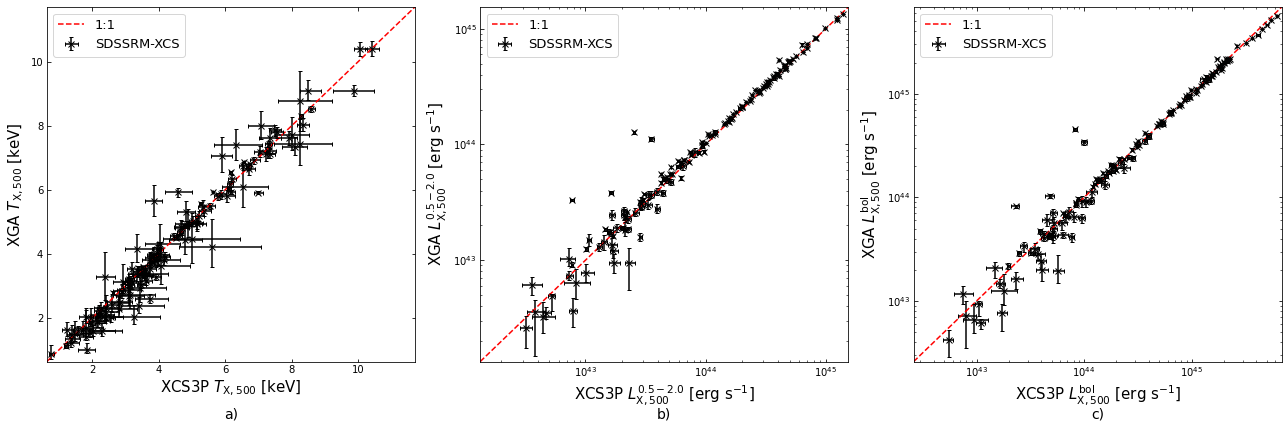

In [13]:
direct_comparison_plot([xcs3p_tx, xcs3p_lx52, xcs3p_lxbol], [sdss_tx, sdss_lx, sdss_lxbol], 
                       [r"XCS3P $T_{\rm{X, 500}}$ [keV]", r"XCS3P $L^{\rm{0.5-2.0}}_{\rm{X, 500}}$ [erg s$^{-1}$]", 
                        r"XCS3P $L^{\rm{bol}}_{\rm{X, 500}}$ [erg s$^{-1}$]"], 
                       [r"XGA $T_{\rm{X, 500}}$ [keV]", r"XGA $L^{\rm{0.5-2.0}}_{\rm{X, 500}}$ [erg s$^{-1}$]", 
                        r"XGA $L^{\rm{bol}}_{\rm{X, 500}}$ [erg s$^{-1}$]"],
                       r"SDSSRM-XCS", (18, 6), ['linear', 'log', 'log'], ['linear', 'log', 'log'], 
                       savepath='../../outputs/figures/sdssxcs_Tx_Lxb_Lx52_comp.pdf')

  0%|                                                                               | 0/20000 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/emcee-3.1.1-py3.8.egg/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 882.49it/s]


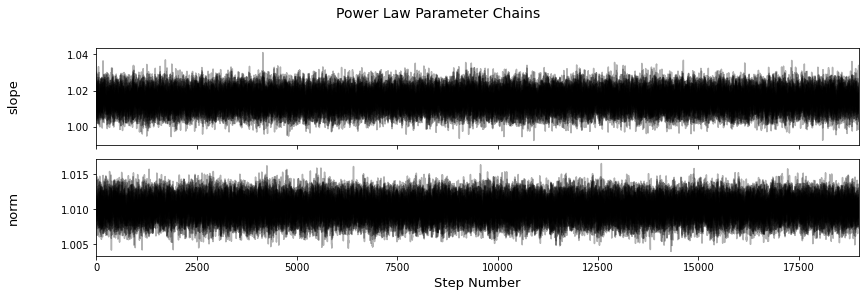

Removed no burn in


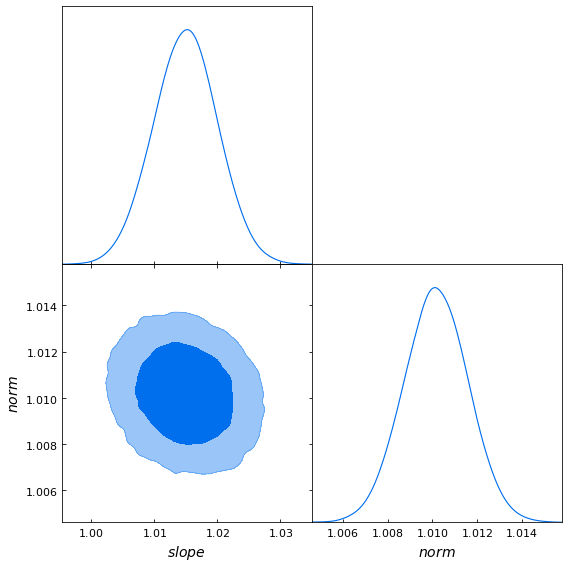

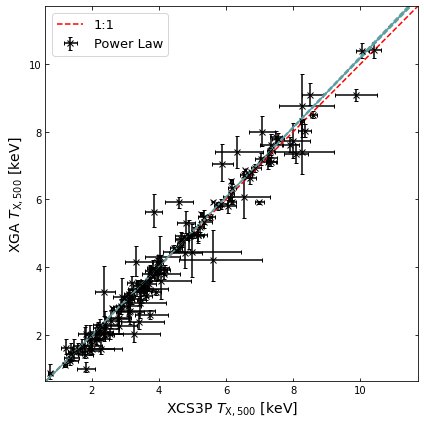

slope=1.015 +0.005 -0.005 [1sig]
norm=1.01 +0.001 -0.001 [1sig]


In [14]:
fit_comp(xcs3p_tx, sdss_tx, [[-5, 5], [-5, 5]], r"XCS3P $T_{\rm{X, 500}}$ [keV]", 
         r"XGA $T_{\rm{X, 500}}$ [keV]", Quantity(5.5, 'keV'),  num_steps=20000, view_chains=True, 
         linear=False, view_corner=True)

100%|██████████████████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 888.76it/s]


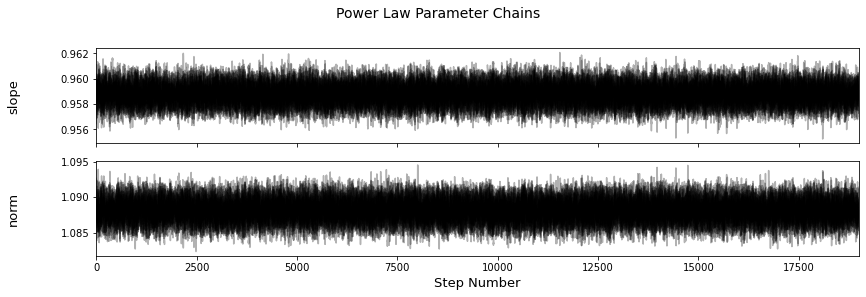

Removed no burn in


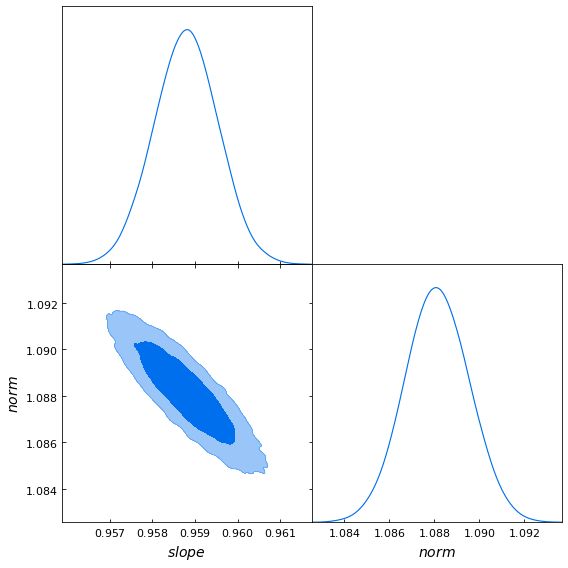

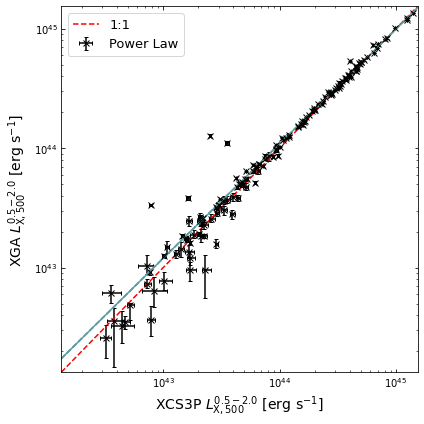

slope=0.959 +0.001 -0.001 [1sig]
norm=1.088 +0.001 -0.001 [1sig]


In [15]:
fit_comp(xcs3p_lx52, sdss_lx, [[-10, 10], [-20, 20]], r"XCS3P $L^{\rm{0.5-2.0}}_{\rm{X, 500}}$ [erg s$^{-1}$]", 
         r"XGA $L^{\rm{0.5-2.0}}_{\rm{X, 500}}$ [erg s$^{-1}$]", Quantity(1e+44, 'erg/s'),  num_steps=20000, 
         view_chains=True, linear=False, view_corner=True, xscale='log', yscale='log')

100%|█████████████████████████████████████████████████████████████████| 20000/20000 [00:19<00:00, 1028.68it/s]


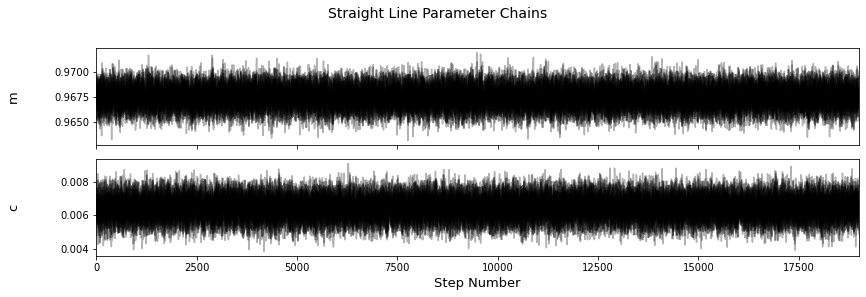

Removed no burn in


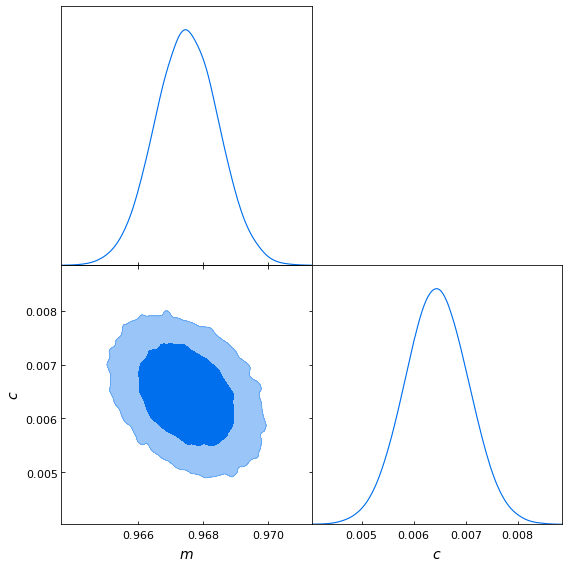

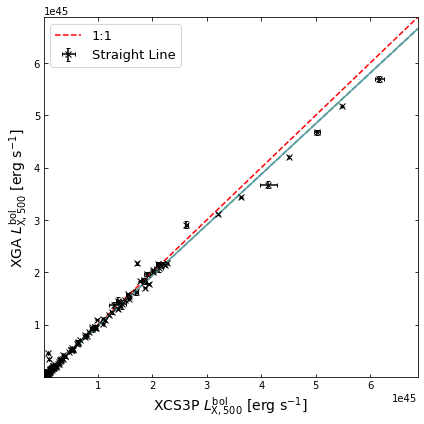

m=0.967 +0.001 -0.001 [1sig]
c=0.006 +0.001 -0.001 [1sig]


In [16]:
fit_comp(xcs3p_lxbol, sdss_lxbol, [[-10, 10], [-20, 20]], r"XCS3P $L^{\rm{bol}}_{\rm{X, 500}}$ [erg s$^{-1}$]", 
         r"XGA $L^{\rm{bol}}_{\rm{X, 500}}$ [erg s$^{-1}$]", Quantity(5e+44, 'erg/s'),  num_steps=20000, 
         view_chains=True, linear=True, view_corner=True, xscale='linear', yscale='linear')

### Within $R_{2500}$

In [17]:
print('{s} out of {t} XGA Tx measurements were successful'.format(s=np.isfinite(sdss_tx2500[:, 0]).sum(), 
                                                                  t=len(sdss_tx2500)))
print('{s} out of {t} XGA Lx52 measurements were successful'.format(s=np.isfinite(sdss_lx2500[:, 0]).sum(), 
                                                                    t=len(sdss_lx2500)))
print('{s} out of {t} XGA Lxbol measurements were successful'.format(s=np.isfinite(sdss_lxbol2500[:, 0]).sum(), 
                                                                    t=len(sdss_lxbol2500)))

131 out of 131 XGA Tx measurements were successful
131 out of 131 XGA Lx52 measurements were successful
131 out of 131 XGA Lxbol measurements were successful


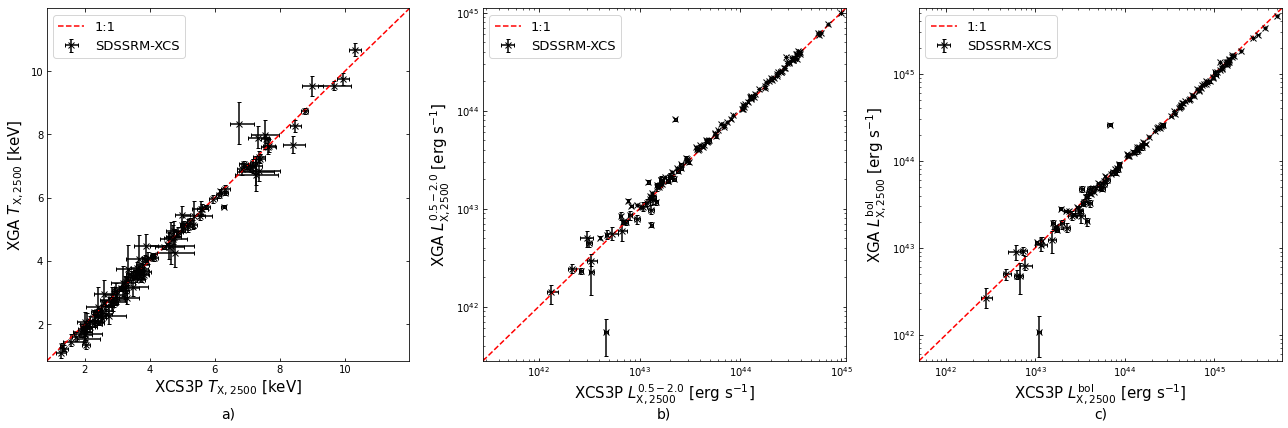

In [18]:
direct_comparison_plot([xcs3p_tx2500, xcs3p_lx522500, xcs3p_lxbol2500], [sdss_tx2500, sdss_lx2500, sdss_lxbol2500], 
                       [r"XCS3P $T_{\rm{X, 2500}}$ [keV]", r"XCS3P $L^{\rm{0.5-2.0}}_{\rm{X, 2500}}$ [erg s$^{-1}$]", 
                        r"XCS3P $L^{\rm{bol}}_{\rm{X, 2500}}$ [erg s$^{-1}$]"], 
                       [r"XGA $T_{\rm{X, 2500}}$ [keV]", r"XGA $L^{\rm{0.5-2.0}}_{\rm{X, 2500}}$ [erg s$^{-1}$]", 
                        r"XGA $L^{\rm{bol}}_{\rm{X, 2500}}$ [erg s$^{-1}$]"],
                       r"SDSSRM-XCS", (18, 6), ['linear', 'log', 'log'], ['linear', 'log', 'log'], 
                       savepath='../../outputs/figures/sdssxcs_Tx_Lxb_Lx52_r2500_comp.pdf')

100%|█████████████████████████████████████████████████████████████████| 20000/20000 [00:19<00:00, 1034.72it/s]


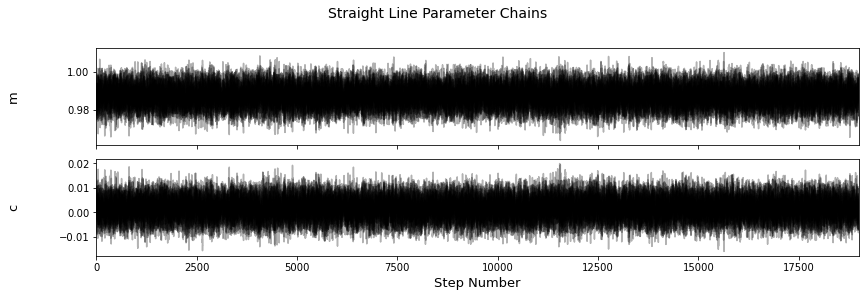

Removed no burn in


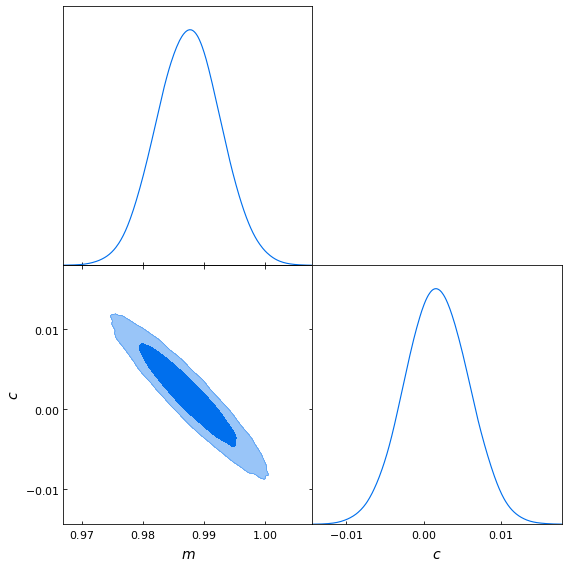

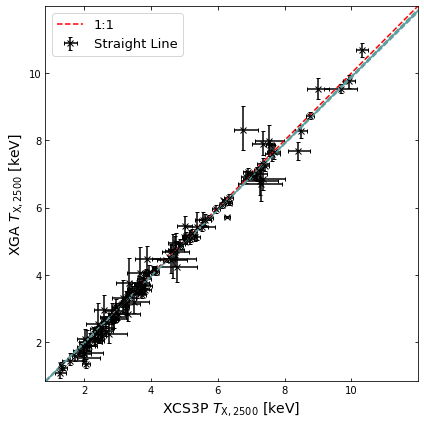

m=0.987 +0.005 -0.005 [1sig]
c=0.002 +0.004 -0.004 [1sig]


In [19]:
fit_comp(xcs3p_tx2500, sdss_tx2500, [[-5, 5], [-5, 5]], r"XCS3P $T_{\rm{X, 2500}}$ [keV]", 
         r"XGA $T_{\rm{X, 2500}}$ [keV]", Quantity(5.5, 'keV'),  num_steps=20000, view_chains=True, 
         linear=True, view_corner=True)

100%|██████████████████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 905.30it/s]


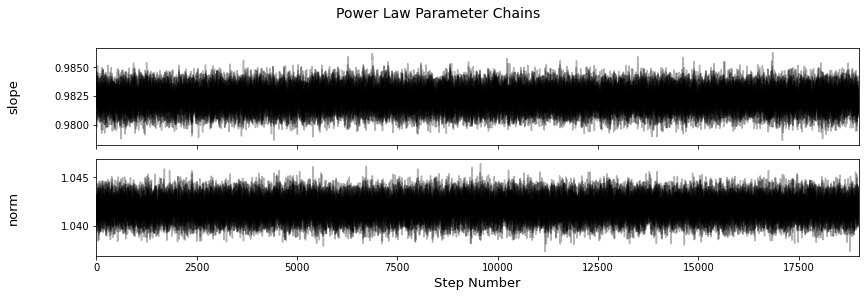

Removed no burn in


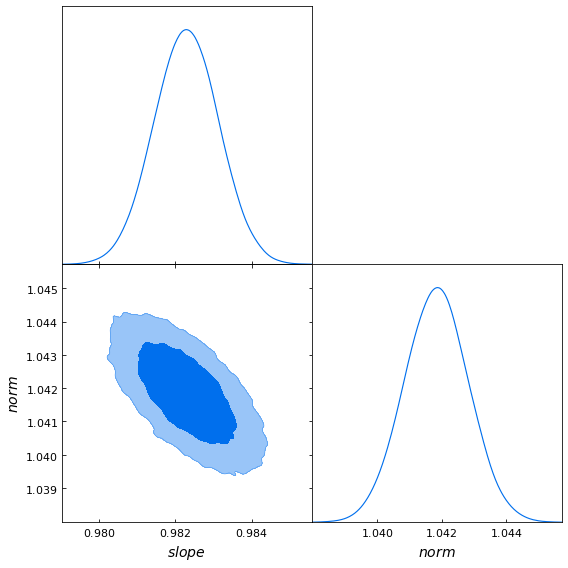

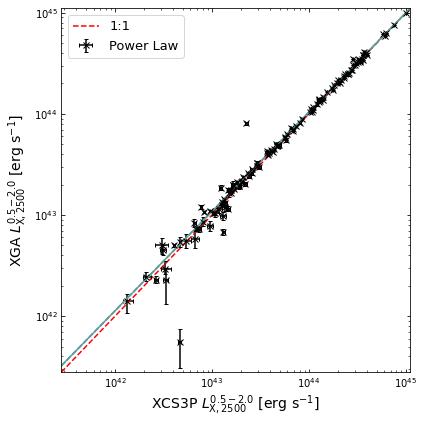

slope=0.982 +0.001 -0.001 [1sig]
norm=1.042 +0.001 -0.001 [1sig]


In [20]:
fit_comp(xcs3p_lx522500, sdss_lx2500, [[-10, 10], [-20, 20]], 
         r"XCS3P $L^{\rm{0.5-2.0}}_{\rm{X, 2500}}$ [erg s$^{-1}$]", 
         r"XGA $L^{\rm{0.5-2.0}}_{\rm{X, 2500}}$ [erg s$^{-1}$]", Quantity(1e+44, 'erg/s'),  num_steps=20000, 
         view_chains=True, linear=False, view_corner=True, xscale='log', yscale='log')